In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import rosbag
from tqdm import tqdm

from visualization import papermode
from scipy import interpolate as interp

papermode(plt, size=12)


data_path = Path.home() / "code" / "202206" / "terrain-data"
workshop_data = data_path / "workshop"

figs_path = Path("figs")
workshop_figs = figs_path / "workshop_response"
workshop_figs.mkdir(parents=True, exist_ok=True)

files = [*workshop_data.glob("*.bag")]


Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
idxs = [f.stem.split("_")[0] for f in files]
dfs = {i: {} for i in idxs}

for f in tqdm(files):
    bag = rosbag.Bag(f)
    idx = f.stem.split("_")[0]

    dfs[idx]["IL"] = pd.DataFrame(columns=["t", "IL"])
    gen = bag.read_messages(topics=["/left_drive/status/battery_current"])
    msgs = list(gen)
    dfs[idx]["IL"]["t"] = [msg.timestamp.to_time() for msg in msgs]
    dfs[idx]["IL"]["IL"] = [msg.message.data for msg in msgs]

    dfs[idx]["IR"] = pd.DataFrame(columns=["t", "IR"])
    gen = bag.read_messages(topics=["/right_drive/status/battery_current"])
    msgs = list(gen)
    dfs[idx]["IR"]["t"] = [msg.timestamp.to_time() for msg in msgs]
    dfs[idx]["IR"]["IR"] = [msg.message.data for msg in msgs]

    dfs[idx]["VR"] = pd.DataFrame(columns=["t", "VR"])
    gen = bag.read_messages(topics=["/right_drive/status/battery_voltage"])
    msgs = list(gen)
    dfs[idx]["VR"]["t"] = [msg.timestamp.to_time() for msg in msgs]
    dfs[idx]["VR"]["VR"] = [msg.message.data for msg in msgs]

    dfs[idx]["VL"] = pd.DataFrame(columns=["t", "VL"])
    gen = bag.read_messages(topics=["/left_drive/status/battery_voltage"])
    msgs = list(gen)
    dfs[idx]["VL"]["t"] = [msg.timestamp.to_time() for msg in msgs]
    dfs[idx]["VL"]["VL"] = [msg.message.data for msg in msgs]

    dfs[idx]["BAT"] = pd.DataFrame(columns=["t", "VB", "IB", "estop"])
    gen = bag.read_messages(topics=["/mcu/status"])
    msgs = list(gen)
    dfs[idx]["BAT"]["t"] = [msg.timestamp.to_time() for msg in msgs]
    dfs[idx]["BAT"]["VB"] = [msg.message.measured_battery for msg in msgs]
    dfs[idx]["BAT"]["IB"] = [msg.message.current_battery for msg in msgs]
    dfs[idx]["BAT"]["estop"] = [not(msg.message.stop_engaged) for msg in msgs]

    dfs[idx]["cmd_vel"] = pd.DataFrame(columns=["t", "lin", "ang"])
    gen = bag.read_messages(topics=["/warthog_velocity_controller/cmd_vel" if idx.startswith("D") else "/cmd_vel"])
    msgs = list(gen)
    dfs[idx]["cmd_vel"]["t"] = [msg.timestamp.to_time() for msg in msgs]
    dfs[idx]["cmd_vel"]["lin"] = [msg.message.linear.x for msg in msgs]
    dfs[idx]["cmd_vel"]["ang"] = [msg.message.angular.z for msg in msgs]

    dfs[idx]["velL"] = pd.DataFrame(columns=["t", "velL"])
    gen = bag.read_messages(topics=["/left_drive/status/speed"])
    msgs = list(gen)
    dfs[idx]["velL"]["t"] = [msg.timestamp.to_time() for msg in msgs]
    dfs[idx]["velL"]["velL"] = [msg.message.data for msg in msgs]

    dfs[idx]["velR"] = pd.DataFrame(columns=["t", "velR"])
    gen = bag.read_messages(topics=["/right_drive/status/speed"])
    msgs = list(gen)
    dfs[idx]["velR"]["t"] = [msg.timestamp.to_time() for msg in msgs]
    dfs[idx]["velR"]["velR"] = [msg.message.data for msg in msgs]




100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


In [3]:
def best_join_time_idx(idx: int, prim_df: pd.DataFrame, seco_df: pd.DataFrame):
    """Get to secondary time from first time"""
    prim_time = prim_df.t
    seco_time = seco_df.t

    best_idx = (seco_time - prim_time[idx]).abs().argmin()
    return best_idx


In [4]:
for k in dfs.keys():
    batt_df = dfs[k]["BAT"]
    dfs[k]["BAT"]["PB"] = batt_df.IB * batt_df.VB
    
    mask = dfs[k]["IR"].IR < 3000
    y_mask = dfs[k]["IR"].IR[mask]
    x_mask = dfs[k]["IR"].t[mask]
    x = dfs[k]["IR"].t
    f = interp.interp1d(x_mask, y_mask, fill_value="extrapolate")
    dfs[k]["IR"].IR = f(x)
    
    mask = dfs[k]["IL"].IL < 3000
    y_mask = dfs[k]["IL"].IL[mask]
    x_mask = dfs[k]["IL"].t[mask]
    x = dfs[k]["IL"].t
    f = interp.interp1d(x_mask, y_mask, fill_value="extrapolate")
    dfs[k]["IL"].IL = f(x)
    
    dfs[k]["ML"] = L_mot  =  dfs[k]["IL"].copy()
    dfs[k]["MR"] = R_mot = dfs[k]["IR"].copy()

    VL = dfs[k]["VL"].copy()
    VR = dfs[k]["VR"].copy()

    IV_L_idx = pd.Series({idx: best_join_time_idx(idx, L_mot, VL) for idx in L_mot.index})
    IV_R_idx = pd.Series({idx: best_join_time_idx(idx, R_mot, VR) for idx in R_mot.index})

    dfs[k]["ML"]["VL"] = pd.Series({idx: VL.VL.iloc[IV_L_idx.iloc[idx]] for idx in L_mot.index})
    dfs[k]["MR"]["VR"] = pd.Series({idx: VR.VR.iloc[IV_R_idx.iloc[idx]] for idx in R_mot.index})

    dfs[k]["motor"] = full_mot = dfs[k]["ML"].copy()
    R_mot = dfs[k]["MR"].copy()
    
    LR_idx = pd.Series({idx: best_join_time_idx(idx, full_mot, R_mot) for idx in full_mot.index})
    dfs[k]["motor"]["IR"] = pd.Series(
        {idx:R_mot.IR.iloc[LR_idx.iloc[idx]] for idx in full_mot.index}
    )
    dfs[k]["motor"]["VR"] = pd.Series(
        {idx:R_mot.VR.iloc[LR_idx.iloc[idx]] for idx in full_mot.index}
    )

    dfs[k]["w"] = velocities = dfs[k]["velL"].copy()
    velR = dfs[k]["velR"].copy()
    
    velLR_idx = pd.Series({idx: best_join_time_idx(idx, velocities, velR) for idx in velocities.index})
    dfs[k]["w"]["velR"] = pd.Series(
        {idx:velR.velR.iloc[velLR_idx.iloc[idx]] for idx in velocities.index}
    )

    velocities = dfs[k]["w"].copy()
    elec_w_idx = pd.Series({idx: best_join_time_idx(idx, full_mot, velocities) for idx in full_mot.index})
    dfs[k]["motor"]["velL"] = pd.Series(
        {idx:velocities.velL.iloc[elec_w_idx.iloc[idx]] for idx in full_mot.index}
    )
    dfs[k]["motor"]["velR"] = pd.Series(
        {idx:velocities.velR.iloc[elec_w_idx.iloc[idx]] for idx in full_mot.index}
    )


In [5]:
class Velocity:
    lin: float
    ang: float

    def __init__(self, data):
        self.lin = data["cmd_vel"].lin
        self.ang =data["cmd_vel"].ang

In [6]:
def response_plot(abbr):
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(sharex=True, nrows=5, figsize=(6,19))
    data = dfs[abbr]
    vels = Velocity(data)

    data_mask = data["motor"].IL.notna()
    time_mask = data["motor"].t[data_mask]
    t_lim = {
        "min": time_mask.min(),
        "max": time_mask.max()
    }

    filt_data = {idx:dat.copy() for idx, dat in data.items()}
    def filter_data_time(fdat: pd.DataFrame, k:str):
        mask = (fdat[k].t >= t_lim["min"]) & (fdat[k].t <= t_lim["max"])
        fdat[k] = fdat[k].loc[mask]
    filter_data_time(filt_data, "cmd_vel")
    filter_data_time(filt_data, "motor")
    filter_data_time(filt_data, "BAT")
    filter_data_time(filt_data, "w")

    ax1.plot(filt_data["BAT"].t, filt_data["BAT"].estop, "bo", label="E-STOP")
    ax1.plot(filt_data["cmd_vel"].t, filt_data["cmd_vel"].lin, "m", label="lin")
    ax1.plot(filt_data["cmd_vel"].t, filt_data["cmd_vel"].ang, "k:", label="ang")
    ax1.set_title(
        f"Lin {vels.lin.min()}:{vels.lin.mean()}:{vels.lin.max()}\n"
        f"Ang {vels.ang.min()}:{vels.ang.mean()}:{vels.ang.max()}"
    )
    ax1.legend()

    ax2.plot(filt_data["w"].t, filt_data["w"].velL, "g", label="wL")
    ax2.plot(filt_data["w"].t, filt_data["w"].velR, "r", label="wR")
    ax2.set_title(f"{abbr} - Motor velocities")
    ax2.legend()

    ax3.plot(filt_data["motor"].t, filt_data["motor"].IL, "g:", label="IL")
    ax3.plot(filt_data["motor"].t, filt_data["motor"].IR, "r:", label="IR")
    ax3.plot(filt_data["BAT"].t, filt_data["BAT"].IB, "b:", label=r"$I_{BAT}$")
    ax3.set_title(f"{abbr} - Motor currents")
    ax3.legend()

    ax4.plot(filt_data["motor"].t, filt_data["motor"].VL, "g--", label="VL")
    ax4.plot(filt_data["motor"].t, filt_data["motor"].VR, "r--", label="VR")
    ax4.plot(filt_data["BAT"].t, filt_data["BAT"].VB, "b--", label=r"$V_{BAT}$")
    ax4.set_title(f"{abbr} - Motor voltages")
    ax4.legend()

    fmot = filt_data["motor"]
    filt_data["motor"]["fL"] = fmot.VL * fmot.IL / fmot.velL
    filt_data["motor"]["fR"] = fmot.VR * fmot.IR / fmot.velR

    ax5.plot(filt_data["motor"].t, filt_data["motor"].fL, "g--", label="fL")
    ax5.plot(filt_data["motor"].t, filt_data["motor"].fR, "r--", label="fR")
    ax5.set_title(f"{abbr} - Estimated torques")
    ax5.legend()


    fig.savefig(workshop_figs / f"{abbr}_response.jpg", bbox_inches="tight")

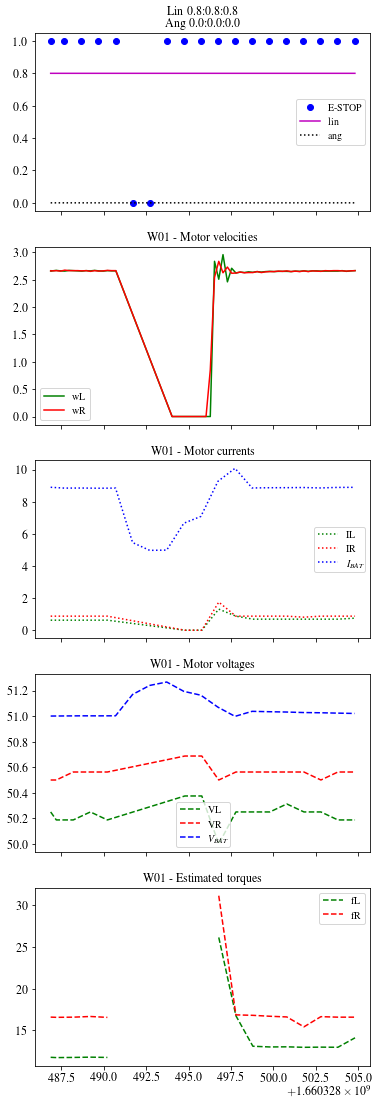

In [7]:
response_plot("W01")

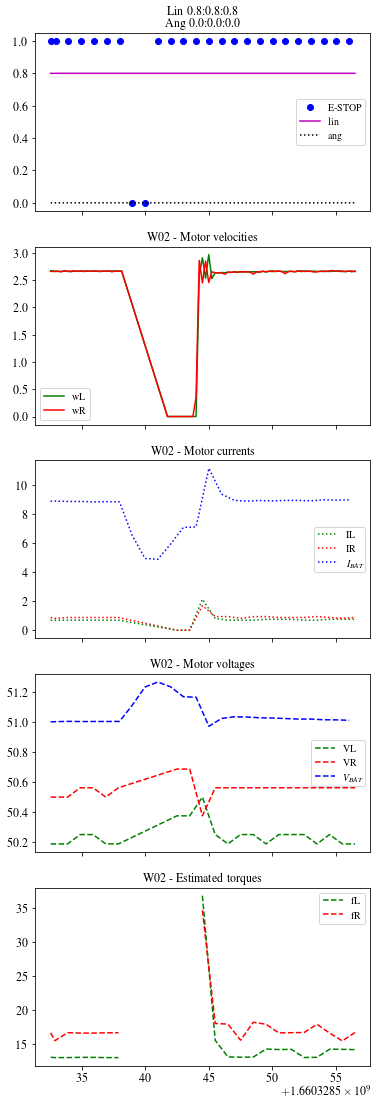

In [8]:
response_plot("W02")

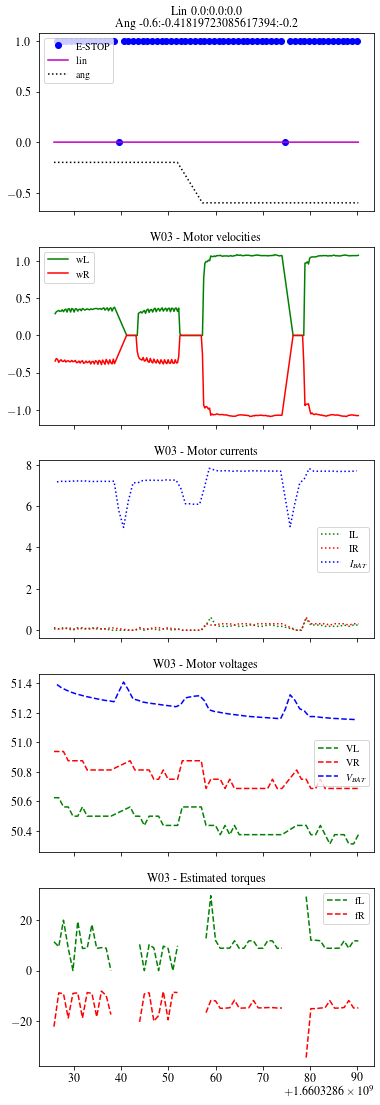

In [9]:
response_plot("W03")

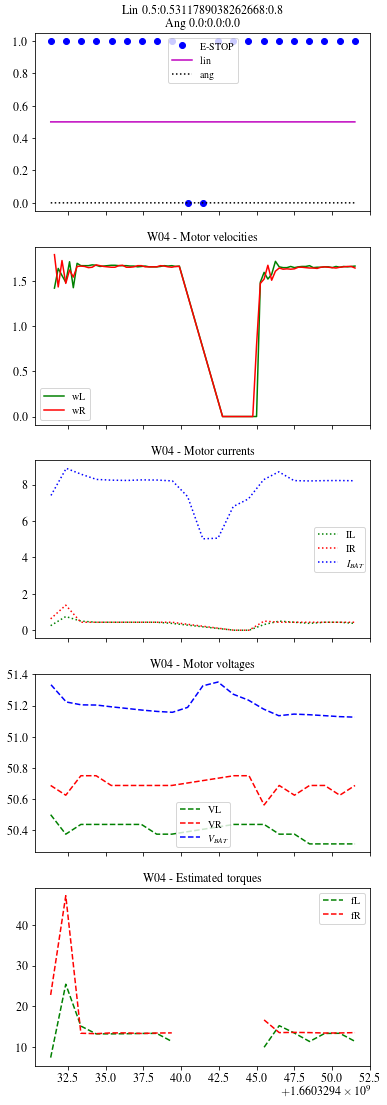

In [10]:
response_plot("W04")

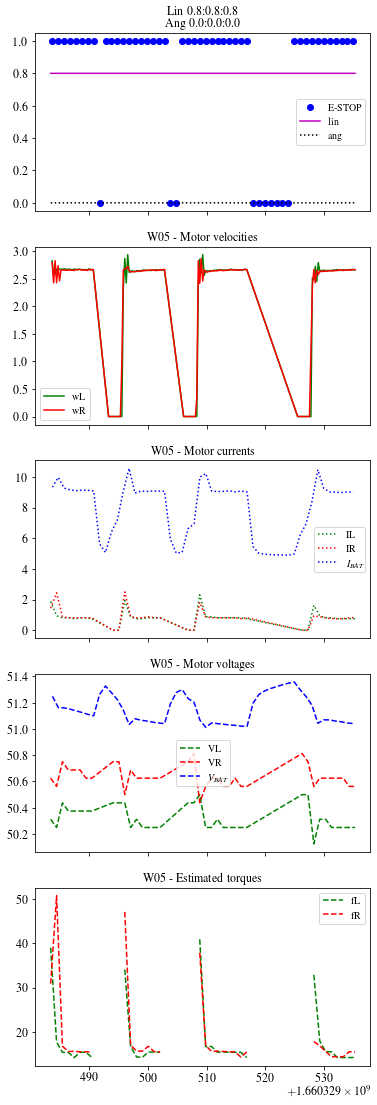

In [11]:
response_plot("W05")

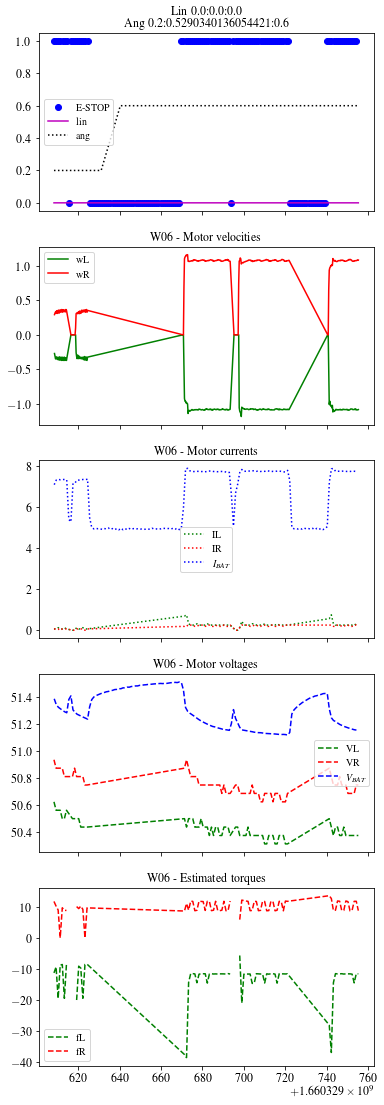

In [12]:
response_plot("W06")

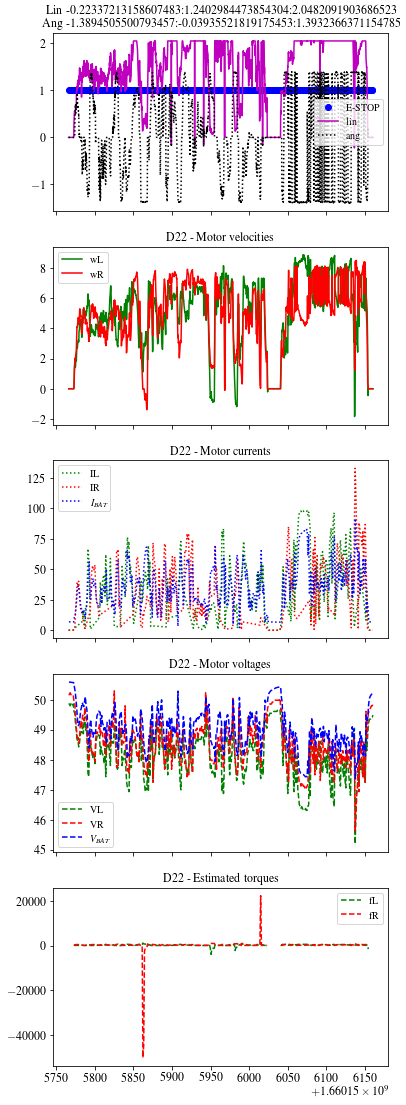

In [13]:
response_plot("D22")